# Preface

Алгоритмы **квантовых вычислений** изучены далеко не так хорошо как классические алгоритмы. Но они демонстрируют высокий потенциал, и программнные инструменты для их реализации уже доступны разработчикам. Чтобы познакомиться с данными инструментами, а также оценить эффективность решений предоставляемых квантовыми вычислениями для сферы финтеха, мы реализуем несколько алгоритмов.

# QAOA vs ?

## Dataset - S&P 500 stock data

### Описание

[Данный датасет](https://www.kaggle.com/datasets/camnugent/sandp500/data) представляет собой данные за пять лет по рынку акций списка [S&P 500](https://stockanalysis.com/list/sp-500-stocks/).

### Содержание

Файл данных содержит следующие колонки:

- Date - in format: yy-mm-dd
- Open - price of the stock at market open (this is NYSE data so all in USD Billions)
- High - Highest price reached in the day
- Low Close - Lowest price reached in the day
- Volume - Number of shares traded
- Name - the stock's ticker name

### Предобработка

### Выбор пула стоков

Современные NISQ системы показывают приемлимые результаты для данной модели в пределе пула размером 20, поэтому мы ограничимся таким числом.
В целях исследования, разобъем исследуемые данные на три группы - по максимальному достигнутому значению цены акции (High) для каждой компании (Name). Выберем интервал 'до \\$30B', 'от \\$30B до \\$100B', и 'от \\$100B'. В первых двух интервалах выберем по пять компаний, в последнем десять.

In [228]:
import pandas as pd
pf_df = pd.read_csv('./datasets/all_stocks_5yr.csv')

In [229]:
pf_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    619040 non-null  str    
 1   open    619029 non-null  float64
 2   high    619032 non-null  float64
 3   low     619032 non-null  float64
 4   close   619040 non-null  float64
 5   volume  619040 non-null  int64  
 6   Name    619040 non-null  str    
dtypes: float64(4), int64(1), str(2)
memory usage: 33.1 MB


In [230]:
pf_df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [231]:
pf_df.describe()

,open,high,low,close,volume
count,619029.000000,619032.000000,619032.000000,619040.000000,6.190400e+05
mean,83.023334,83.778311,82.256096,83.043763,4.321823e+06
std,97.378769,98.207519,96.507421,97.389748,8.693610e+06
min,1.620000,1.690000,1.500000,1.590000,0.000000e+00
25%,40.220000,40.620000,39.830000,40.245000,1.070320e+06
50%,62.590000,63.150000,62.020000,62.620000,2.082094e+06
75%,94.370000,95.180000,93.540000,94.410000,4.284509e+06
max,2044.000000,2067.990000,2035.110000,2049.000000,6.182376e+08


In [232]:
# Уберем из списка стоки с NA данными
pf_df.drop(pf_df.loc[pf_df['open'].isna(), 'Name'].isin(pf_df['Name']).index, inplace=True)
pf_df.drop(pf_df.loc[pf_df['high'].isna(), 'Name'].isin(pf_df['Name']).index, inplace=True)
pf_df.drop(pf_df.loc[pf_df['low'].isna(), 'Name'].isin(pf_df['Name']).index, inplace=True)

In [233]:
# Преобразование типов
pf_df = pf_df.convert_dtypes()

In [234]:
pf_df.info()

<class 'pandas.DataFrame'>
Index: 619029 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    619029 non-null  string 
 1   open    619029 non-null  Float64
 2   high    619029 non-null  Float64
 3   low     619029 non-null  Float64
 4   close   619029 non-null  Float64
 5   volume  619029 non-null  Int64  
 6   Name    619029 non-null  string 
dtypes: Float64(4), Int64(1), string(2)
memory usage: 40.7 MB


In [235]:
pf_df['date'] = pd.to_datetime(pf_df['date'])
pf_df.info()

<class 'pandas.DataFrame'>
Index: 619029 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    619029 non-null  datetime64[us]
 1   open    619029 non-null  Float64       
 2   high    619029 non-null  Float64       
 3   low     619029 non-null  Float64       
 4   close   619029 non-null  Float64       
 5   volume  619029 non-null  Int64         
 6   Name    619029 non-null  string        
dtypes: Float64(4), Int64(1), datetime64[us](1), string(1)
memory usage: 40.7 MB


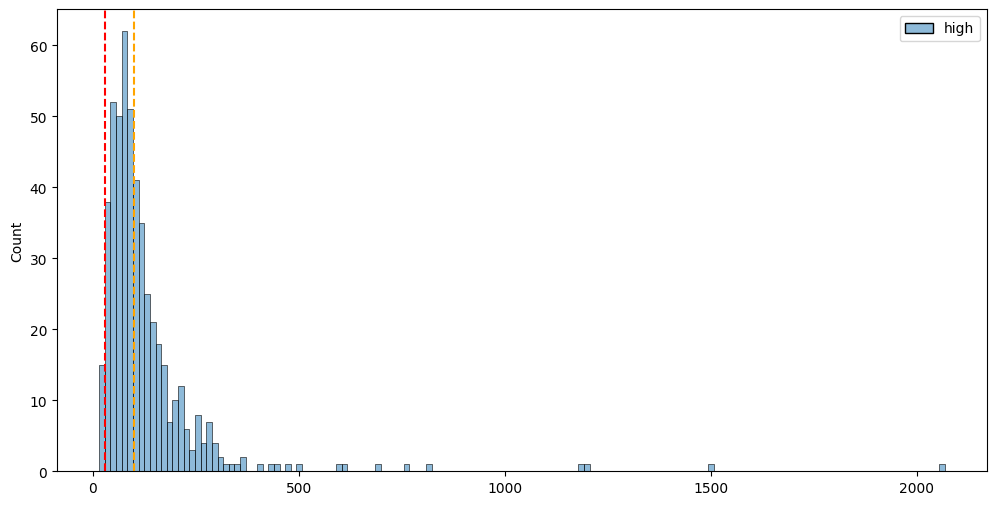

In [236]:
# Группы выбора на графике
import matplotlib.pyplot as plt
import seaborn as sns

high_max = pf_df[['high', 'Name']].groupby(['Name']).max()

_, ax = plt.subplots(figsize=(12, 6))
sns.histplot(data=high_max, bins=150, ax=ax)
plt.axvline(x=30, color='red', linestyle='--')
plt.axvline(x=100, color='orange', linestyle='--')
#TODO: use plotly or add plot without ouliers

In [237]:
pf_df1 = high_max[high_max['high'] <= 30].sample(5)
pf_df2 = high_max[high_max['high'].between(30, 100, inclusive='right')].sample(5)
pf_df3 = high_max[high_max['high'] > 100].sample(10)
#pf_df3
#pf_df[pf_df['high']high_max < 30]
#high_max[high_max['high'] < 30].sample(5)
pf_df[pf_df['Name'].isin(pf_df1.index)]['date'].value_counts()

date
2014-04-17    5
2014-04-21    5
2014-04-22    5
2014-04-23    5
2014-04-24    5
             ..
2014-04-10    4
2014-04-11    4
2014-04-14    4
2014-04-15    4
2014-04-16    4
Name: count, Length: 1259, dtype: int64

<Axes: ylabel='Frequency'>

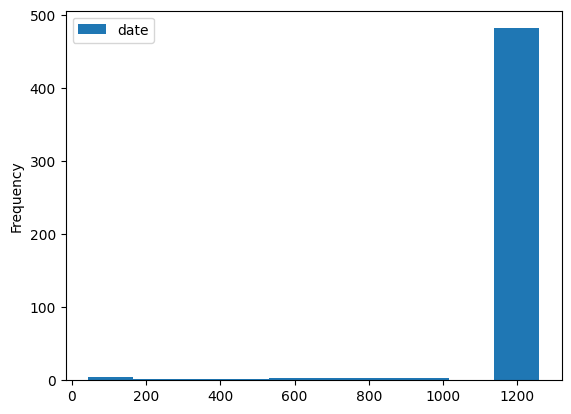

In [238]:
# Давайте узнаем как много организаций не имеют данных на полный период времени
pf_df[['date', 'Name']].groupby(['Name']).count().plot.hist()

In [239]:
# Попробуем использовать для исследования только полные данные.
dates = pf_df['date'].sort_values().unique()
pf_df = pf_df.groupby(['Name']).filter(lambda x: x['date'].count() == len(dates))
high_max = pf_df[['high', 'Name']].groupby(['Name']).max()
pf_df1 = high_max[high_max['high'] <= 30].sample(3, random_state=1)
pf_df2 = high_max[high_max['high'].between(30, 100, inclusive='right')].sample(3, random_state=1)
pf_df3 = high_max[high_max['high'] > 100].sample(6, random_state=1)
pf20_df = pf_df[pf_df['Name'].isin(pf_df1.index)]
pf20_df['class'] = 'C'
pf20_df = pd.concat([pf20_df, pf_df[pf_df['Name'].isin(pf_df2.index)]], ignore_index=True).fillna('B')
pf20_df = pd.concat([pf20_df, pf_df[pf_df['Name'].isin(pf_df3.index)]], ignore_index=True).fillna('A')

Text(0.5, 0.925, 'Closing prices, $B')

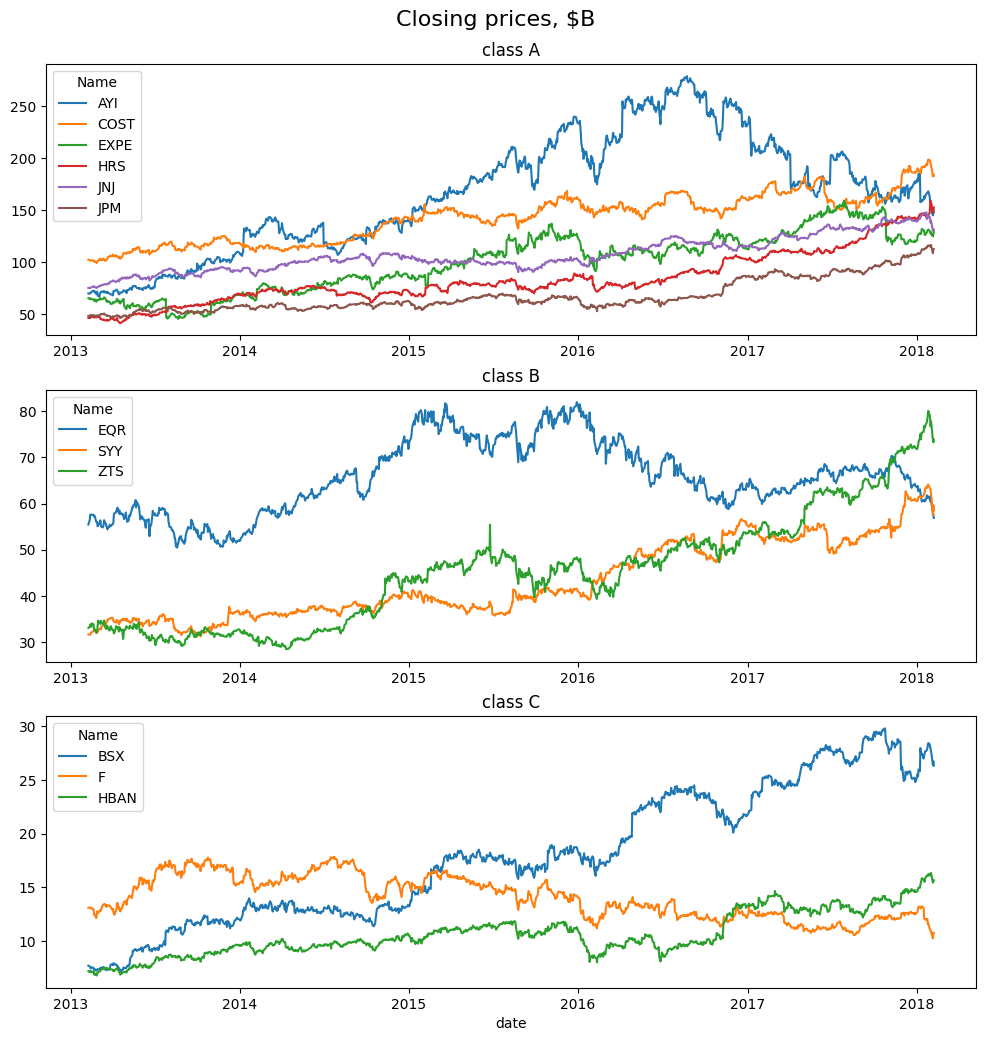

In [240]:
fig, ax = plt.subplots(3, 1, figsize=(12, 12))
sns.lineplot(data=pf20_df[pf20_df['class'] == 'A'], x='date', y='close', hue='Name', ax=ax[0]).set(xlabel=None, ylabel=None, title='class A')
sns.lineplot(data=pf20_df[pf20_df['class'] == 'B'], x='date', y='close', hue='Name', ax=ax[1]).set(xlabel=None, ylabel=None, title='class B')
sns.lineplot(data=pf20_df[pf20_df['class'] == 'C'], x='date', y='close', hue='Name', ax=ax[2]).set(ylabel=None, title='class C')
fig.suptitle('Closing prices, $B', fontsize=16, y=0.925)
#g = sns.FacetGrid(pf20_df.sort_values('class'), row='class', aspect=4.)
#g.map(sns.lineplot, 'date', 'high', 'Name')
#g.add_legend()

In [241]:
#date80 = dates[int(0.8*len(dates))]
date_test  = max(dates) - pd.Timedelta(365, 'D')
pf20train_df = pf20_df[pf20_df['date'] <= date_test]
pf20test_df = pf20_df[pf20_df['date'] > date_test]
len(pf20train_df) + len(pf20test_df) == len(pf20_df)

True

In [242]:
pf20train_df = pf20train_df[['date', 'close', 'Name']].pivot(index='date', columns='Name', values='close').sort_values('date')
pf20test_df = pf20test_df[['date', 'close', 'Name']].pivot(index='date', columns='Name', values='close').sort_values('date')

In [243]:
pf20train_df
pf20_df['date'].value_counts()

date
2013-02-08    12
2013-02-11    12
2013-02-12    12
2013-02-13    12
2013-02-14    12
              ..
2018-02-01    12
2018-02-02    12
2018-02-05    12
2018-02-06    12
2018-02-07    12
Name: count, Length: 1259, dtype: int64

In [244]:
pd.Timestamp('2018-02-07') - pd.Timestamp('2013-02-08')

Timedelta('1825 days 00:00:00')

In [245]:
pf20_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 15108 entries, 0 to 15107
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    15108 non-null  datetime64[us]
 1   open    15108 non-null  Float64       
 2   high    15108 non-null  Float64       
 3   low     15108 non-null  Float64       
 4   close   15108 non-null  Float64       
 5   volume  15108 non-null  Int64         
 6   Name    15108 non-null  string        
 7   class   15108 non-null  str           
dtypes: Float64(4), Int64(1), datetime64[us](1), str(1), string(1)
memory usage: 1018.1 KB


In [246]:
# Вычислим дневную доходность
pf20train_df = pf20train_df.diff() / pf20train_df.shift(1)#.div(pf20train_df.index.diff().days.to_series().to_list(), axis='index') / pf20train_df.shift(1)
pf20test_df = pf20test_df.diff() / pf20test_df.shift(1)#.div(pf20test_df.index.diff().days.to_series().to_list(), axis='index') / pf20test_df.shift(1)
#pf20train_df = pf20train_df.diff() / (pf20train_df.mul(pf20train_df.index.diff().days.to_series().to_list(), axis='index') - pf20train_df.diff())
#pf20test_df = pf20test_df.diff() / (pf20test_df.mul(pf20test_df.index.diff().days.to_series().to_list(), axis='index') - pf20test_df.diff())

In [247]:
pf20train_df = pf20train_df.iloc[1:]
pf20test_df = pf20test_df.iloc[1:]
pf20train_df.info(), pf20test_df.info()

<class 'pandas.DataFrame'>
DatetimeIndex: 1006 entries, 2013-02-11 to 2017-02-07
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AYI     1006 non-null   Float64
 1   BSX     1006 non-null   Float64
 2   COST    1006 non-null   Float64
 3   EQR     1006 non-null   Float64
 4   EXPE    1006 non-null   Float64
 5   F       1006 non-null   Float64
 6   HBAN    1006 non-null   Float64
 7   HRS     1006 non-null   Float64
 8   JNJ     1006 non-null   Float64
 9   JPM     1006 non-null   Float64
 10  SYY     1006 non-null   Float64
 11  ZTS     1006 non-null   Float64
dtypes: Float64(12)
memory usage: 114.0 KB
<class 'pandas.DataFrame'>
DatetimeIndex: 251 entries, 2017-02-09 to 2018-02-07
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AYI     251 non-null    Float64
 1   BSX     251 non-null    Float64
 2   COST    251 non-null    Float64
 3   EQR     251 non-null  

(None, None)

<Axes: xlabel='Name', ylabel='annual daily returns'>

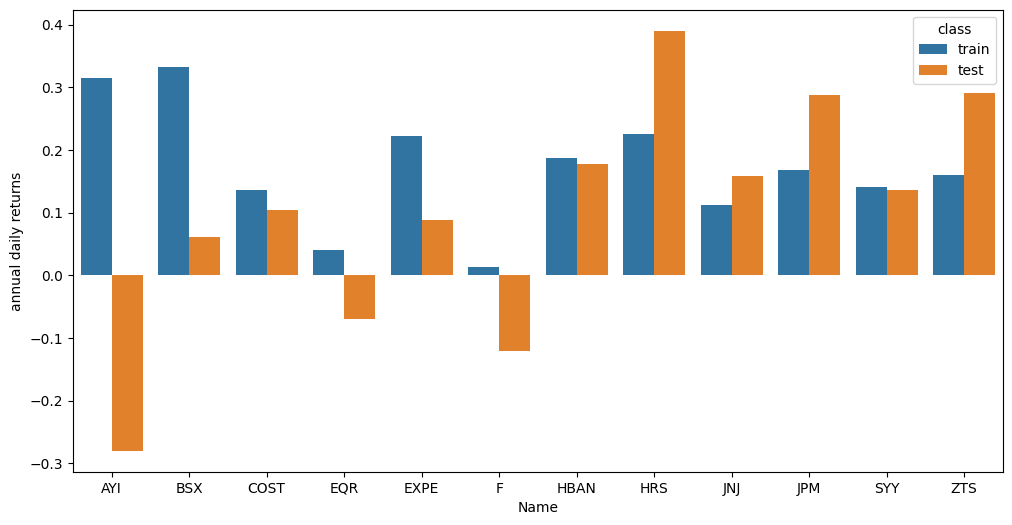

In [248]:
# Получаем годовые значения
pf20train_covann = pf20train_df.cov()*252
pf20test_covann = pf20test_df.cov()*252
pf20train_covann.max(axis=None)
pf20train_drann = pf20train_df.mean()*252
pf20test_drann = pf20test_df.mean()*252
pf20_drann = pf20train_drann.to_frame()
pf20_drann['class'] = 'train'
pf20_drann = pd.concat([pf20_drann, pf20test_drann]).fillna('test')
pf20_drann.columns = ['annual daily returns', 'class']
plt.figure(figsize=(12, 6))
sns.barplot(pf20_drann, x='Name', y='annual daily returns', hue='class')

Text(0.5, 0.95, 'Annualized covariance matrix for daily returns')

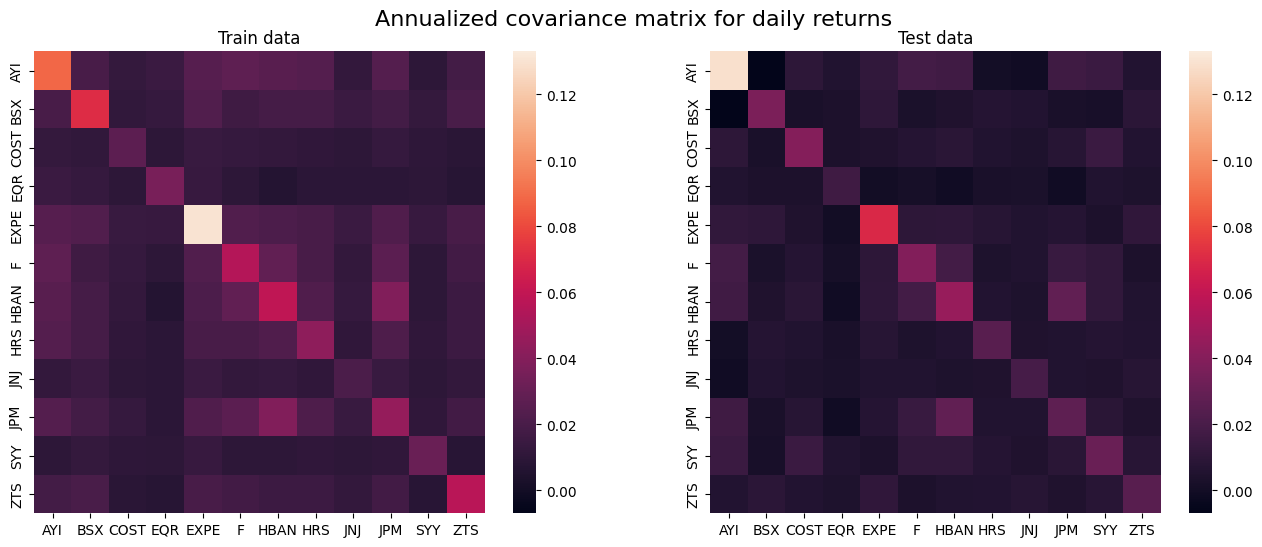

In [249]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
vmin = 0.975 * min(pf20train_covann.min(axis=None), pf20test_covann.min(axis=None))
vmax = 1.025 * max(pf20train_covann.max(axis=None), pf20test_covann.max(axis=None))
sns.heatmap(pf20train_covann, vmin=vmin, vmax=vmax, ax=ax[0]).set(xlabel=None, ylabel=None, title='Train data')
sns.heatmap(pf20test_covann, vmin=vmin, vmax=vmax, ax=ax[1]).set(xlabel=None, ylabel=None, title='Test data')
fig.suptitle('Annualized covariance matrix for daily returns', fontsize=16, y=0.95)

## Implementation

In [321]:
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_optimization.algorithms import MinimumEigenOptimizer
import pennylane as qml
from pennylane import qaoa
import numpy as np
from scipy.optimize import minimize


# Classic (exact) solution
def po_eigs(mu, sigma, budget, risk_factor):
    pf = PortfolioOptimization(mu, sigma, risk_factor, budget)
    qp = pf.to_quadratic_program()
    
    converter = QuadraticProgramToQubo()
    qubo = converter.convert(qp)
    penalty_value = converter.penalty
    
    exact_mes = NumPyMinimumEigensolver()
    optimizer = MinimumEigenOptimizer(exact_mes)
    result_classic = optimizer.solve(qp)

    ising, _ = qubo.to_ising()
    ising_matrix = ising.to_list()

    return result_classic, ising_matrix

# QAOA solution
def po_qaoa(ising_matrix, n_assets, n_layers, n_iter, n_shots=1024, n_levels=1, simulator="lightning.qubit"):
    n_qubits = n_assets * n_levels
    dev = qml.device(simulator, wires=n_qubits)
    
    # Construct PennyLane Hamiltonian from Ising coeffs
    def ising_to_hamiltonian(ising_matrix):
        paulis = []
        coeffs = []

        h = np.real([e[1] for e in ising_matrix[:n_assets]])
        J = np.real([e[1] for e in ising_matrix[n_assets:]])
        
        for i, hi in enumerate(h):
            if abs(hi) > 1e-10:
                coeffs.append(hi)
                paulis.append(qml.PauliZ(i))

        k = 0
        for i in range(len(h)):
            for j in range(i+1, len(h)):
                if abs(J[k]) > 1e-10:
                    coeffs.append(J[k])
                    k += 1
                    paulis.append(qml.PauliZ(i) @ qml.PauliZ(j))
        
        return qml.Hamiltonian(coeffs, paulis)
    
    H_C = ising_to_hamiltonian(ising_matrix)
    H_M = qml.Hamiltonian(np.ones(n_qubits), [qml.PauliX(i) for i in range(n_qubits)])

    # Energy for minimization
    @qml.qnode(dev)
    def energy(params):
        for i in range(n_qubits): qml.Hadamard(wires=i)
        gammas, betas = params[:n_layers], params[n_layers:]
        for g, b in zip(gammas, betas):
            qml.qaoa.layers.cost_layer(g, hamiltonian=H_C)
            qml.qaoa.layers.mixer_layer(b, hamiltonian=H_M)
        return qml.expval(H_C)

    results_qa_t = []
    def energy_x(*, intermediate_result):
        results_qa_t.append(intermediate_result)
        
    result_qa = minimize(energy, np.random.uniform(0, 2*np.pi, 2*n_layers), method='COBYLA', options={'maxiter': n_iter}, callback=energy_x)
  
    # Sampling optimized circuit values
    @qml.qnode(dev, shots=n_shots)
    def sample_portfolio(params):
        for i in range(n_qubits): qml.Hadamard(wires=i)
        gammas, betas = params[:n_layers], params[n_layers:]
        for g, b in zip(gammas, betas):
            qml.qaoa.layers.cost_layer(g, hamiltonian=H_C)
            qml.qaoa.layers.mixer_layer(b, hamiltonian=H_M)
        return qml.sample()

    qa_samples = sample_portfolio(result_qa.x)
    
    # Expectation values of optimized model
    @qml.qnode(dev)
    def expectval_portfolio(params):
        for i in range(n_qubits): qml.Hadamard(wires=i)
        gammas, betas = params[:n_layers], params[n_layers:]
        for g, b in zip(gammas, betas):
            qml.qaoa.layers.cost_layer(g, hamiltonian=H_C)
            qml.qaoa.layers.mixer_layer(b, hamiltonian=H_M)
        return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

    qa_expect = expectval_portfolio(result_qa.x)

    return result_qa, results_qa_t, qa_samples, np.array(qa_expect)


# Discretized weights decoder
def decode_discretized_expval(discretized_expval, n_assets, n_levels):
        weights = []
        for asset in range(n_assets):
            start = asset * n_levels
            bits = np.where(discretized_expval[start:start+n_levels] < 0, 1, 0)
            weight = sum(b * (2**k) for k, b in enumerate(bits)) / (2**(n_levels))
            weights.append(weight)
        return np.array(weights)

In [322]:
mu = pf20train_drann.to_numpy()
sigma = pf20train_covann.to_numpy()

In [323]:
cc, ising = po_eigs(mu, sigma, risk_factor=0.5, budget=4)

In [325]:
qa, qa_t, qa_samples, qa_expect = po_qaoa(ising, n_assets=len(mu), n_layers=3, n_iter=100)

In [326]:
qa_t, qa_expect
w_q = decode_discretized_expval(qa_expect, len(mu), 1)
mu @ cc.x, mu @ w_q#, qa_t
qa_samples

array([[0, 1, 1, ..., 1, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 1, 0, 1],
       [0, 0, 1, ..., 0, 1, 0],
       [1, 1, 1, ..., 1, 0, 0]], shape=(1024, 12))

In [327]:
budget = [3, 4, 5]
risk_factor = [0.3, 0.5, 0.7]
n_layers = [1, 2, 3, 4]
n_iter = [100, 200, 300,]
#n_levels = [1, 2]
#n_shots = [1024, 2048, 3072, 4096]

In [299]:
#import timeit
#
#
#t_list = []
#
#for i in range(10, 20):
#    mu_i = mu[:i]
#    sigma_i = sigma[:i, :i]
#    tt = timeit.timeit(stmt='po_eigs(mu_i, sigma_i, 4, 0.5)', setup='from __main__ import po_eigs, mu_i, sigma_i', number=100)
    #timeit.repeat
#    t_list.append(tt)
#
#sns.lineplot(np.log(t_list))

In [328]:
cc_res = pd.merge(pd.Series(budget, name='budget'), pd.Series(risk_factor, name='risk'), how='cross')
cc_res[['weights', 'ising_matrix']] = cc_res.transform(lambda x: po_eigs(mu, sigma, *x), axis=1)
cc_res['weights'] = cc_res['weights'].transform(lambda x: x.x)

In [329]:
cc_res.head()

,budget,risk,weights,ising_matrix
0,3,0.3,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[(IIIIIIIIIIIZ, (-11.493006989569444+0j)), (II..."
1,3,0.5,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[(IIIIIIIIIIIZ, (-13.154659831494829+0j)), (II..."
2,3,0.7,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[(IIIIIIIIIIIZ, (-14.816312673420207+0j)), (II..."
3,4,0.3,"[1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, ...","[(IIIIIIIIIIIZ, (-7.624403714420938+0j)), (III..."
4,4,0.5,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[(IIIIIIIIIIIZ, (-8.742143059709733+0j)), (III..."


In [330]:
# example
#qa, qa_t, qa_samples, qa_expect = po_qaoa(mu, sigma, risk_factor=0.5, budget=4, penalty_value=pv, n_layers=2, n_iter=100)

In [331]:
qa_res = \
cc_res.merge(pd.Series(n_layers, name='n_layers'), how='cross').\
merge(pd.Series(n_iter, name='n_iterations'), how='cross')
qa_res

,budget,risk,weights,ising_matrix,n_layers,n_iterations
0,3,0.3,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[(IIIIIIIIIIIZ, (-11.493006989569444+0j)), (II...",1,100
1,3,0.3,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[(IIIIIIIIIIIZ, (-11.493006989569444+0j)), (II...",1,200
2,3,0.3,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[(IIIIIIIIIIIZ, (-11.493006989569444+0j)), (II...",1,300
3,3,0.3,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[(IIIIIIIIIIIZ, (-11.493006989569444+0j)), (II...",2,100
4,3,0.3,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[(IIIIIIIIIIIZ, (-11.493006989569444+0j)), (II...",2,200
...,...,...,...,...,...,...
103,5,0.7,"[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[(IIIIIIIIIIIZ, (-4.903452136576838+0j)), (III...",3,200
104,5,0.7,"[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[(IIIIIIIIIIIZ, (-4.903452136576838+0j)), (III...",3,300
105,5,0.7,"[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[(IIIIIIIIIIIZ, (-4.903452136576838+0j)), (III...",4,100
106,5,0.7,"[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[(IIIIIIIIIIIZ, (-4.903452136576838+0j)), (III...",4,200


In [332]:
qa_res[['qa_result', 'result_over_time', 'samples', 'qa_weights']] = pd.NA

In [333]:
qa_res.head()

,budget,risk,weights,ising_matrix,n_layers,n_iterations,qa_result,result_over_time,samples,qa_weights
0,3,0.3,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[(IIIIIIIIIIIZ, (-11.493006989569444+0j)), (II...",1,100,<NA>,<NA>,<NA>,<NA>
1,3,0.3,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[(IIIIIIIIIIIZ, (-11.493006989569444+0j)), (II...",1,200,<NA>,<NA>,<NA>,<NA>
2,3,0.3,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[(IIIIIIIIIIIZ, (-11.493006989569444+0j)), (II...",1,300,<NA>,<NA>,<NA>,<NA>
3,3,0.3,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[(IIIIIIIIIIIZ, (-11.493006989569444+0j)), (II...",2,100,<NA>,<NA>,<NA>,<NA>
4,3,0.3,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[(IIIIIIIIIIIZ, (-11.493006989569444+0j)), (II...",2,200,<NA>,<NA>,<NA>,<NA>


In [334]:
qa_chunks = [qa_res[i*10:(i+1)*10] for i in range(11)]

In [335]:
qa_chunks[-1]

,budget,risk,weights,ising_matrix,n_layers,n_iterations,qa_result,result_over_time,samples,qa_weights
100,5,0.7,"[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[(IIIIIIIIIIIZ, (-4.903452136576838+0j)), (III...",2,200,<NA>,<NA>,<NA>,<NA>
101,5,0.7,"[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[(IIIIIIIIIIIZ, (-4.903452136576838+0j)), (III...",2,300,<NA>,<NA>,<NA>,<NA>
102,5,0.7,"[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[(IIIIIIIIIIIZ, (-4.903452136576838+0j)), (III...",3,100,<NA>,<NA>,<NA>,<NA>
103,5,0.7,"[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[(IIIIIIIIIIIZ, (-4.903452136576838+0j)), (III...",3,200,<NA>,<NA>,<NA>,<NA>
104,5,0.7,"[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[(IIIIIIIIIIIZ, (-4.903452136576838+0j)), (III...",3,300,<NA>,<NA>,<NA>,<NA>
105,5,0.7,"[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[(IIIIIIIIIIIZ, (-4.903452136576838+0j)), (III...",4,100,<NA>,<NA>,<NA>,<NA>
106,5,0.7,"[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[(IIIIIIIIIIIZ, (-4.903452136576838+0j)), (III...",4,200,<NA>,<NA>,<NA>,<NA>
107,5,0.7,"[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[(IIIIIIIIIIIZ, (-4.903452136576838+0j)), (III...",4,300,<NA>,<NA>,<NA>,<NA>


In [338]:
qa_res2 = qa_res.copy()
qa_res2[['qa_result', 'result_over_time', 'samples', 'qa_weights']] = \
qa_res2.apply(lambda x: po_qaoa(x['ising_matrix'], n_assets=len(mu), n_layers=x['n_layers'], n_iter=x['n_iterations']), result_type='expand', axis=1)

In [339]:
qa_res2

,budget,risk,weights,ising_matrix,n_layers,n_iterations,qa_result,result_over_time,samples,qa_weights
0,3,0.3,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[(IIIIIIIIIIIZ, (-11.493006989569444+0j)), (II...",1,100,"{'x': [2.4207053953371975, 5.652921141029419],...","[{'x': [2.3887474223376706, 5.615312880145875]...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, ...","[0.7408416444257959, 0.7799444386836638, 0.512..."
1,3,0.3,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[(IIIIIIIIIIIZ, (-11.493006989569444+0j)), (II...",1,200,"{'x': [3.1172128466688647, 2.991335368102063],...","[{'x': [3.1544254682757353, 3.1168749823313346...","[[1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0], [0, 1, ...","[0.04262990211059643, 0.047565881903194905, 0...."
2,3,0.3,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[(IIIIIIIIIIIZ, (-11.493006989569444+0j)), (II...",1,300,"{'x': [5.296506136990532, 1.5707818615198033],...","[{'x': [5.270115017381565, 1.5150447429784304]...","[[1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0], [0, 1, ...","[1.9713506001217684e-16, 1.6271164103576208e-1..."
3,3,0.3,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[(IIIIIIIIIIIZ, (-11.493006989569444+0j)), (II...",2,100,"{'x': [3.6301089209180177, 5.649769415171509, ...","[{'x': [3.4972157596767626, 6.5784284667182185...","[[0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0], [0, 0, ...","[-3.434018038136165e-09, -3.3679076114870483e-..."
4,3,0.3,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[(IIIIIIIIIIIZ, (-11.493006989569444+0j)), (II...",2,200,"{'x': [4.57803979734026, 3.319020824703538, 4....","[{'x': [4.308915590202964, 3.235199906792665, ...","[[1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0], [1, 0, ...","[0.49048410482250143, 0.5066971880957029, 0.45..."
...,...,...,...,...,...,...,...,...,...,...
103,5,0.7,"[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[(IIIIIIIIIIIZ, (-4.903452136576838+0j)), (III...",3,200,"{'x': [5.678122406837057, 0.9542668952033042, ...","[{'x': [5.705545130031335, 0.921633405982551, ...","[[1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0], [0, 0, ...","[-0.090011972639974, -0.1250012945301666, 0.03..."
104,5,0.7,"[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[(IIIIIIIIIIIZ, (-4.903452136576838+0j)), (III...",3,300,"{'x': [0.7057670747900677, 5.664017474458394, ...","[{'x': [-0.1973555151448722, 6.265690226127489...","[[0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0], [1, 1, ...","[-0.10738696890210075, -0.2511407132190432, 0...."
105,5,0.7,"[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[(IIIIIIIIIIIZ, (-4.903452136576838+0j)), (III...",4,100,"{'x': [4.482015501126842, 1.8578409659809156, ...","[{'x': [4.53036860498384, 1.9436609451581368, ...","[[1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0], [1, 0, ...","[-0.15040123231176894, -0.18821264573498542, 0..."
106,5,0.7,"[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[(IIIIIIIIIIIZ, (-4.903452136576838+0j)), (III...",4,200,"{'x': [6.173479840932609, 3.9888296717130753, ...","[{'x': [6.181055515568639, 3.9730720605027288,...","[[0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1], [1, 1, ...","[0.0070132022211444305, -0.034082940081353846,..."


In [340]:
qa_res2.to_csv('datasets/output_qaoa/po_results.csv', index=False)

In [341]:
pf20train_df.to_csv('datasets/output_qaoa/train_data.csv', index=False)
pf20test_df.to_csv('datasets/output_qaoa/test_data.csv', index=False)

In [345]:
qa_res3 = qa_res2.drop(columns=['ising_matrix', 'qa_result'])

In [351]:
qa_res3['result_over_time'] = qa_res3['result_over_time'].transform(lambda x: [x_i.fun for x_i in x])

In [355]:
qa_res3.to_csv('datasets/output_qaoa/po_results2.csv', index=False)

In [356]:
qa_res3.head()

,budget,risk,weights,n_layers,n_iterations,result_over_time,samples,qa_weights
0,3,0.3,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",1,100,"[-24.6561630985358, -24.6561630985358, -24.656...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, ...","[0.7408416444257959, 0.7799444386836638, 0.512..."
1,3,0.3,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",1,200,"[0.33358986933421586, 0.33358986933421586, 0.3...","[[1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0], [0, 1, ...","[0.04262990211059643, 0.047565881903194905, 0...."
2,3,0.3,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",1,300,"[0.5780834692871849, 0.5780834692871849, 0.578...","[[1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0], [0, 1, ...","[1.9713506001217684e-16, 1.6271164103576208e-1..."
3,3,0.3,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",2,100,"[20.816389363165776, 20.816389363165776, 2.757...","[[0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0], [0, 0, ...","[-3.434018038136165e-09, -3.3679076114870483e-..."
4,3,0.3,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",2,200,"[16.64174207567648, 16.64174207567648, 4.71851...","[[1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0], [1, 0, ...","[0.49048410482250143, 0.5066971880957029, 0.45..."


In [103]:
#timeit.timeit(stmt='po_qaoa(mu, sigma, 0.5, 4, pv, 2, 100)', setup='from __main__ import po_qaoa, mu, sigma, pv', number=1)

145.5492385159996

In [836]:
#from scipy.spatial import distance

#distance.hamming(cc.x, qa_samples.value_counts().reset_index().loc[0].to_numpy()[:10])
#distance.hamming(cc.x, qa_bin)

In [837]:
# получить DF (mu, sigma) X budget X n_layers X n_iter